# Module example

Can be found here: https://github.com/pierre-rouanet/dtw

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math

import astropy.io.fits as pf
from collections import defaultdict

from dtw import dtw, accelerated_dtw
from fastdtw import fastdtw

%matplotlib inline

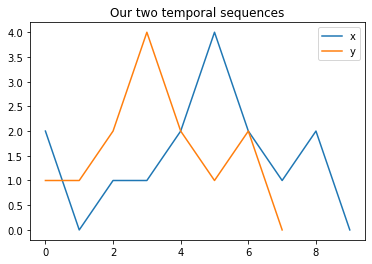

In [2]:
# We define two sequences x, y as numpy array
# where y is actually a sub-sequence from x
x = np.array([2, 0, 1, 1, 2, 4, 2, 1, 2, 0]).reshape(-1, 1)
y = np.array([1, 1, 2, 4, 2, 1, 2, 0]).reshape(-1, 1)

plt.plot(x, label='x')
plt.plot(y, label='y')
plt.title('Our two temporal sequences')
plt.legend()

0.1111111111111111


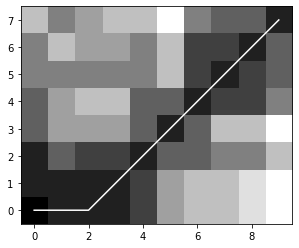

In [3]:
euclidean_norm = lambda x, y: np.abs(x - y)

d, cost_matrix, acc_cost_matrix, path = dtw(x, y, dist=euclidean_norm)

print(d)

plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.show()

In [4]:
path

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([0, 0, 0, 1, 2, 3, 4, 5, 6, 7]))

In [5]:
zipped_path = zip(path[0], path[1])

path_dict = defaultdict(list)
for i, j in zipped_path:
    path_dict[j].append(i)
    
    
aligned_x = []    
for i, j in path_dict.items():
    aj = [x[t] for t in j]
    aligned_x.insert(i, np.mean(aj))

In [6]:
aligned_x

[1.0, 1.0, 2.0, 4.0, 2.0, 1.0, 2.0, 0.0]

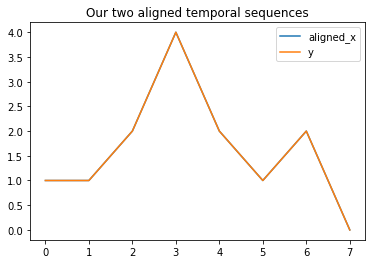

In [7]:
plt.plot(aligned_x, label='aligned_x')
plt.plot(y, label='y')
plt.title('Our two aligned temporal sequences')
plt.legend()

# Testing on stellar data

In [8]:
def get_flux_and_wavelength(file):
    flux = pf.getdata(file)
    spec_header = pf.getheader(file)
    
    wl_i = spec_header['CRVAL1'] # Coordinate value of position in degrees, specified in CRPIX.
    wl_step = spec_header['CDELT1'] # Increment-per-pixel of axis n, in degrees
    wavelength = np.arange(flux.size)*wl_step+wl_i
    
    return flux, wavelength

In [9]:
def zero_clip_flux(a):
    return np.clip(a, 0., None)

In [10]:
ardata = pf.open('spectra/ardata.fits')
data = ardata[1].data

wl_ardata = data['WAVELENGTH']
# arcturus_flux = zero_clip_flux(data['ARCTURUS'])
solar_flux = data['SOLARFLUX']
tel_flux = data['TELLURIC']

O primeiro problema ao tentar usar a implementação naive do algoritmo é que ele tem complexidade de tempo e espaço O(N^2), por isso o erro de memória ao tentar usar em vetores com 700 mil elementos

In [8]:
d, cost_matrix, acc_cost_matrix, path = dtw(solar_flux, tel_flux, dist=euclidean_norm)

MemoryError: 

### DTW

Aqui estamos tentando diminuir os vetores de fluxo para conseguir usar esta implementação do algoritmo. Com 2000 elementos, a execução deixa de ser instantânea e passa a demorar ~30 segundos. Além de não conseguirmos aumentar muito mais a quantidade de elememtos, o warp path deste começo parece ser exatamente alinhado.

In [12]:
threshold = 2000

test_solar_flux = solar_flux[:threshold]
test_tel_flux = tel_flux[:threshold]

In [13]:
start = time.time()

d, cost_matrix, acc_cost_matrix, path = dtw(test_solar_flux, test_tel_flux, dist=euclidean_norm)

end = time.time()
print('Elapsed time in seconds: {}'.format(end - start))

Elapsed time in seconds: 18.938528299331665


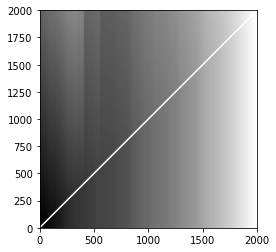

In [14]:
plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.show()

In [39]:
d

0.2627830501049757

In [40]:
all(x == y for x, y in zip(path[0], path[1]))

True

### FastDTW

Com a versão rápida implementada, foi possível usar a norma euclideana como medida de similaridade para computar o caminho ótimo entre dois fluxos: o do Sol e o da estrela telúrica. Nesse caso a complexidade do algoritmo, tanto de tempo quanto de espaço é linear. Aqui é possível observar a mesma coisa que na implementação simples: a primeira metade do warp path entre os fluxos é exatamente alinhado. Isso parece acontecer pois o caminho ótimo entre os fluxos é maior do que o comprimento inicial dos mesmos. No caso de Arcturus com a estrela telúrica o caminho é quase o dobro dos vetores originais. Usar a distância euclideana do scipy piora significativamente a performance do algoritmo, então estamos usando uma implementação simples da norma euclideana.

In [60]:
def plot_spectrum(new_wavelength, new_flux):
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.plot(new_wavelength, new_flux, '-')
    plt.xlabel(r"Wavelength ($\mathrm{\AA}$)")
    plt.ylabel(r"Flux")
#     plt.show()

In [61]:
def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    print(idx - 1, idx)
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1]
    else:
        return array[idx]

In [62]:
TEST_INTERVAL = (236554,716023)

In [63]:
find_nearest(wl_ardata, 4950)

236553 236554


4950.0017

In [64]:
solar_flux = solar_flux[TEST_INTERVAL[0]:]
tel_flux = tel_flux[TEST_INTERVAL[0]:]
wl_ardata = wl_ardata[TEST_INTERVAL[0]:]

In [65]:
def fast_dtw_on_stellar_spectra(x, y, dist):
    distance, path = fastdtw(x, y, dist=dist)
    
    print('Distance: {}'.format(distance))
    
    warp_idxs = all(x == y for x, y in path)
    print('Are all warp path indices aligned? {}'.format(warp_idxs))
    
    fast_path = list(zip(*path))
    plt.plot(fast_path[0], fast_path[1], 'k')
    plt.show()
    
    return fast_path

Distance: 36494.302613320266
Are all warp path indices aligned? False


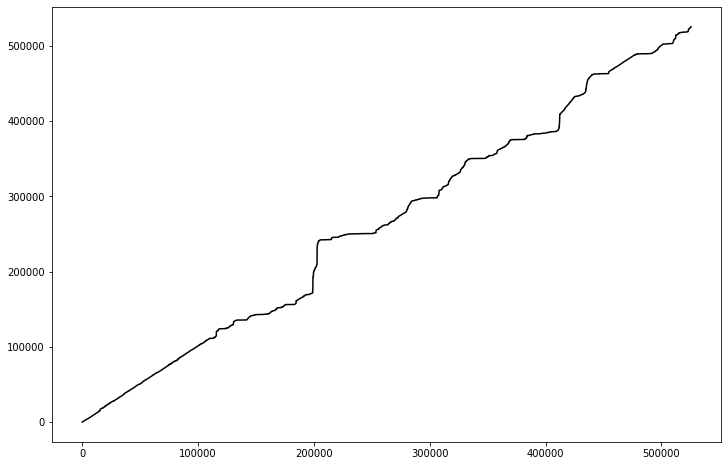

Elapsed time in seconds: 17.123754501342773


In [66]:
start = time.time()


# solar_dtw_path = fast_dtw_on_stellar_spectra(tel_flux, solar_flux, euclidean_norm)
solar_dtw_path = fast_dtw_on_stellar_spectra(tel_flux, solar_flux, euclidean_norm)

end = time.time()
print('Elapsed time in seconds: {}'.format(end - start))

In [67]:
def align_sequence_dtw_path(path, original_seq):
    zipped_path = zip(path[0], path[1])
    
    path_dict = defaultdict(list)
    for i, j in zipped_path:
        path_dict[j].append(i)
        
    aligned_seq = []    
    for i, j in path_dict.items():
        same_path_idx = [original_seq[t] for t in j]
        aligned_seq.insert(i, np.mean(same_path_idx))
        
    return aligned_seq

In [68]:
aligned_tel = align_sequence_dtw_path(solar_dtw_path, tel_flux)

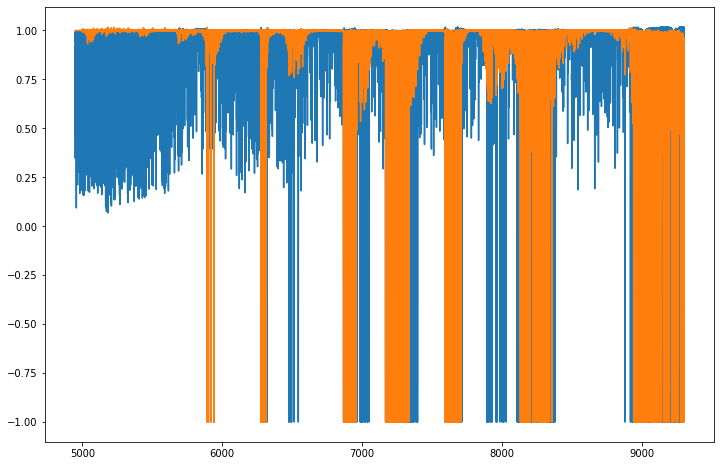

In [69]:
plt.plot(wl_ardata, solar_flux, '-')
plt.plot(wl_ardata, tel_flux, '-')

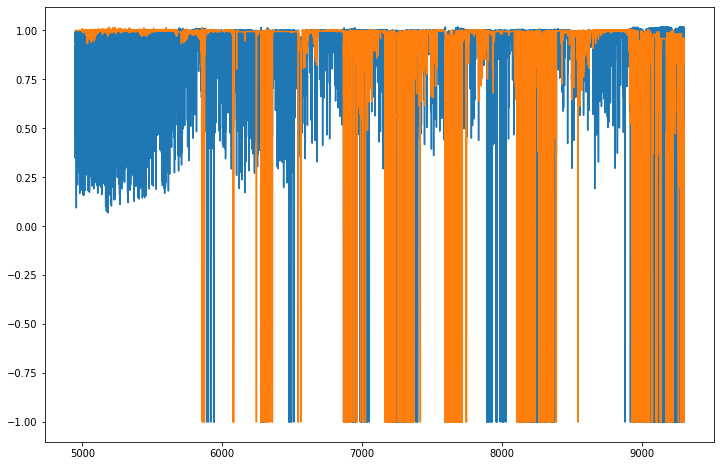

In [70]:
plt.plot(wl_ardata, solar_flux, '-')
plt.plot(wl_ardata, aligned_tel, '-')

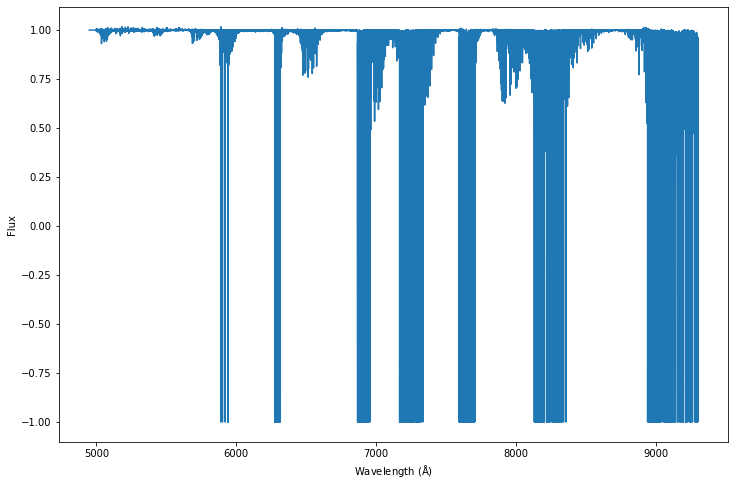

In [71]:
plot_spectrum(wl_ardata, tel_flux)

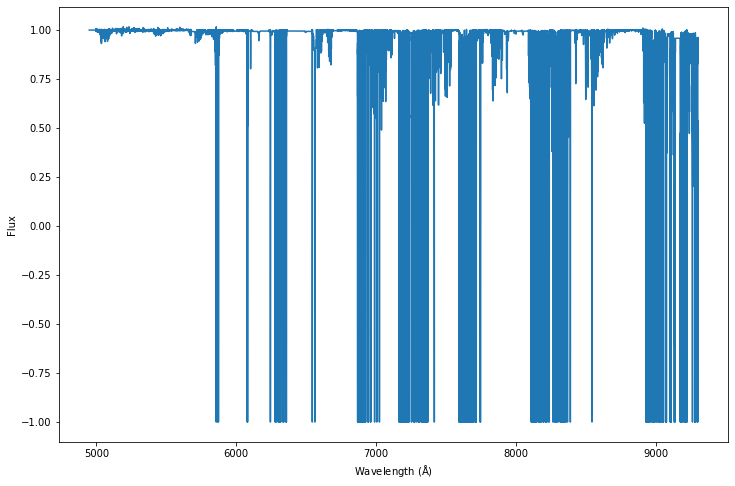

In [72]:
plot_spectrum(wl_ardata, aligned_tel)

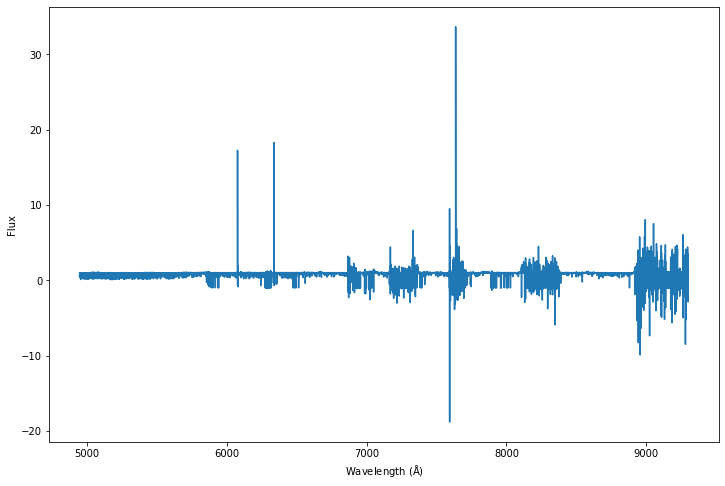

In [73]:
divided_spectrum_sun_aligned = solar_flux / aligned_tel
plot_spectrum(wl_ardata, divided_spectrum_sun_aligned)

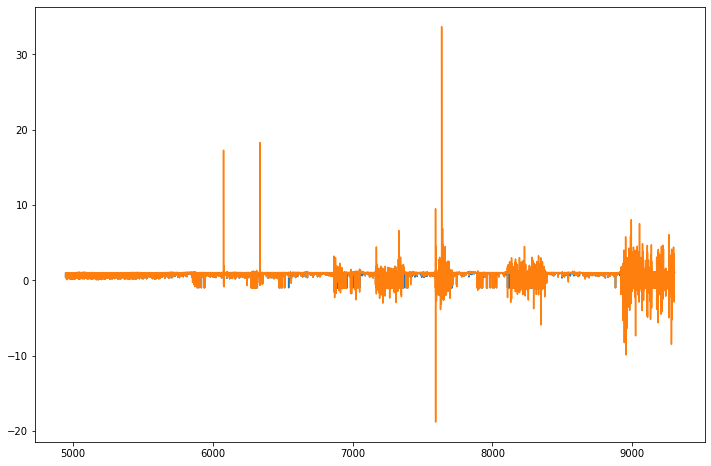

In [75]:
plt.plot(wl_ardata, solar_flux, '-')
plt.plot(wl_ardata, divided_spectrum_sun_aligned, '-')